In [76]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter

CROP = 256

In [77]:
def anisodiff(img,niter=1,lambd=50,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False):

    img = img.astype('float32')
    imgout = img.copy()

    deltaS = np.zeros_like(imgout)
    deltaE = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    gS = np.ones_like(imgout)
    gE = gS.copy()

    if ploton:

        fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
        ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

        ax1.imshow(img,interpolation='nearest')
        ih = ax2.imshow(imgout,interpolation='nearest',animated=True)
        ax1.set_title("Original image")
        ax2.set_title("Iteration 0")

        fig.canvas.draw()

    for ii in np.arange(1,niter):

        deltaS[:-1,: ] = np.diff(imgout,axis=0)
        deltaE[: ,:-1] = np.diff(imgout,axis=1)

        if 0<sigma:
            deltaSf=flt.gaussian_filter(deltaS,sigma);
            deltaEf=flt.gaussian_filter(deltaE,sigma);
        else: 
            deltaSf=deltaS;
            deltaEf=deltaE;

        if option == 1:
            gS = np.exp(-(deltaSf/lambd)**2.)/step[0]
            gE = np.exp(-(deltaEf/lambd)**2.)/step[1]
        elif option == 2:
            gS = 1./(1.+(deltaSf/lambd)**2.)/step[0]
            gE = 1./(1.+(deltaEf/lambd)**2.)/step[1]
        elif option == 3:
            gS = lambd/step[0]
            gE = lambd/step[1]

        E = gE*deltaE
        S = gS*deltaS

        NS[:] = S
        EW[:] = E
        NS[1:,:] -= S[:-1,:]
        EW[:,1:] -= E[:,:-1]


        imgout += gamma*(NS+EW)

        if ploton:
            iterstring = "Iteration %i" %(ii+1)
            ih.set_data(imgout)
            ax2.set_title(iterstring)
            fig.canvas.draw()

            

    return imgout

# Examining data set

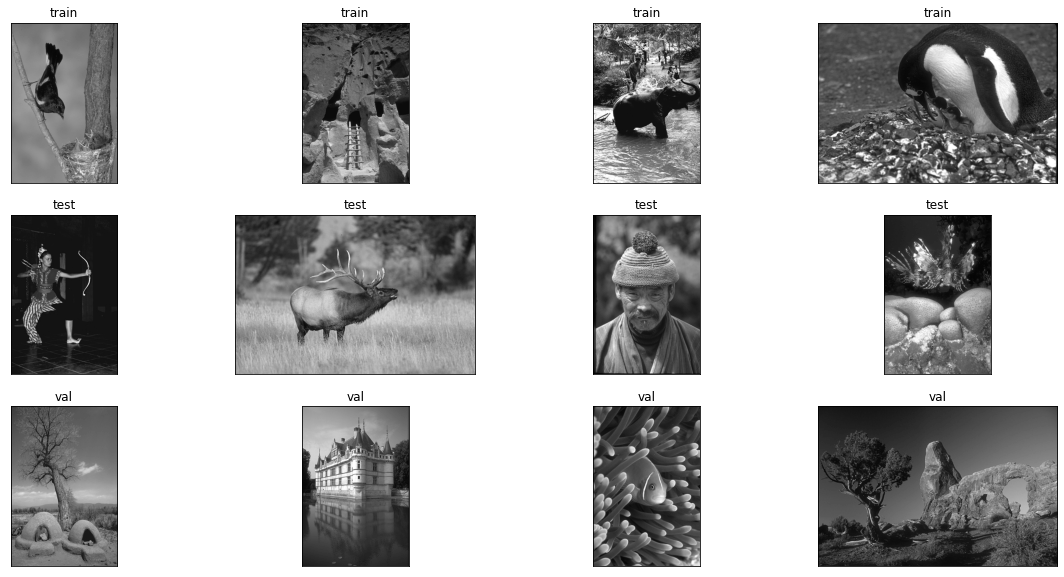

In [78]:
ncols = 4
nrows = 3

fig,axs = plt.subplots(nrows = nrows,ncols = ncols,figsize=(20,10))
test = glob('../images/test/*.jpg')
train = glob('../images/train/*.jpg')
val = glob('../images/val/*.jpg')

imgs = [train,test,val]
titles = ['train','test','val']

for i in range(len(imgs)):
    for j in range(ncols):
        _ = np.random.choice(imgs[i])
        axs[i,j].imshow(cv2.imread(_,cv2.IMREAD_GRAYSCALE),cmap = 'gray')
        axs[i,j].set_xticks([])
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticks([])
        axs[i,j].set_yticklabels([])
        axs[i,j].set_title(titles[i])
        
        
plt.show()

# Inpainting

In [81]:
def open_frame_gauss(frame_num,window=0.5):
    input_path = frame_num
    
    img = np.asarray(cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2GRAY), dtype=np.float32)
    img = cv2.resize(img,(CROP,CROP))
    input_channel = img/np.amax(img)
    wx,wy = np.asarray(np.random.uniform(0,window,2)*img.shape,dtype='int')
    x,y = np.random.choice(img.shape[0]-1-wx),np.random.choice(img.shape[1]-1-wy)
    missing = np.copy(input_channel)
    missing[x:x+wx,y:y+wy] = 0
    return input_channel, missing



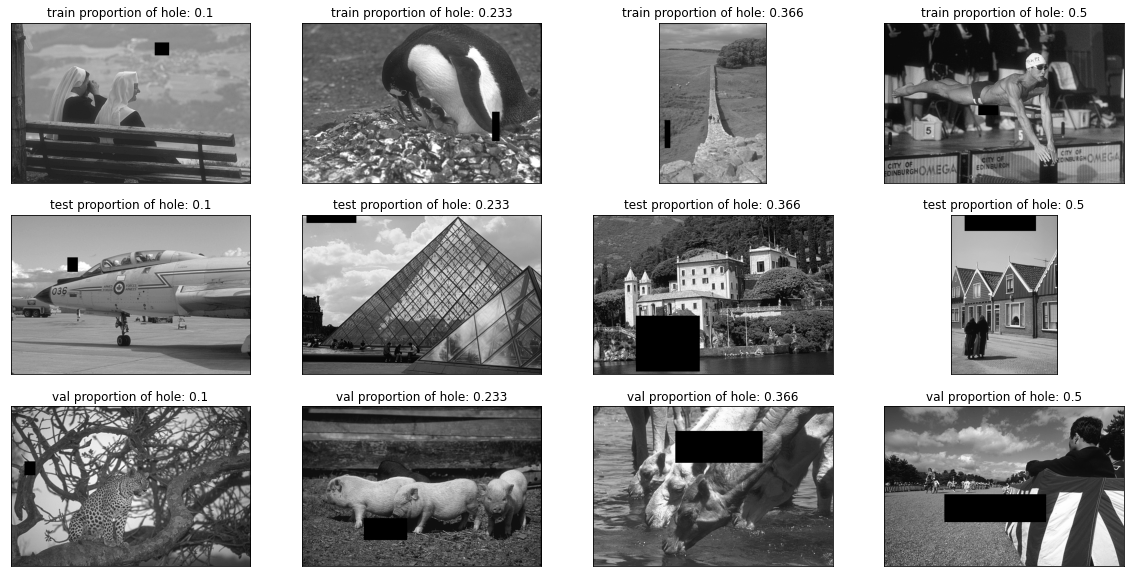

In [37]:
ncols = 4
nrows = 3

fig,axs = plt.subplots(nrows = nrows,ncols = ncols,figsize=(20,10))
test = glob('../images/test/*.jpg')
train = glob('../images/train/*.jpg')
val = glob('../images/val/*.jpg')

imgs = [train,test,val]
titles = ['train','test','val']
var = np.linspace(0.1,0.5,ncols)

for i in range(len(imgs)):
    for j in range(ncols):
        _ = np.random.choice(imgs[i])
        im = open_frame_gauss(_,var[j])
        axs[i,j].imshow(im[1],cmap = 'gray')
        axs[i,j].set_xticks([])
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticks([])
        axs[i,j].set_yticklabels([])
        axs[i,j].set_title(f'{titles[i]} proportion of hole: {int(1e3*var[j])/1e3}')
        
        
plt.show()

## option 1

100%|███████████████████████████████████████| 10/10 [7:28:40<00:00, 2692.04s/it]


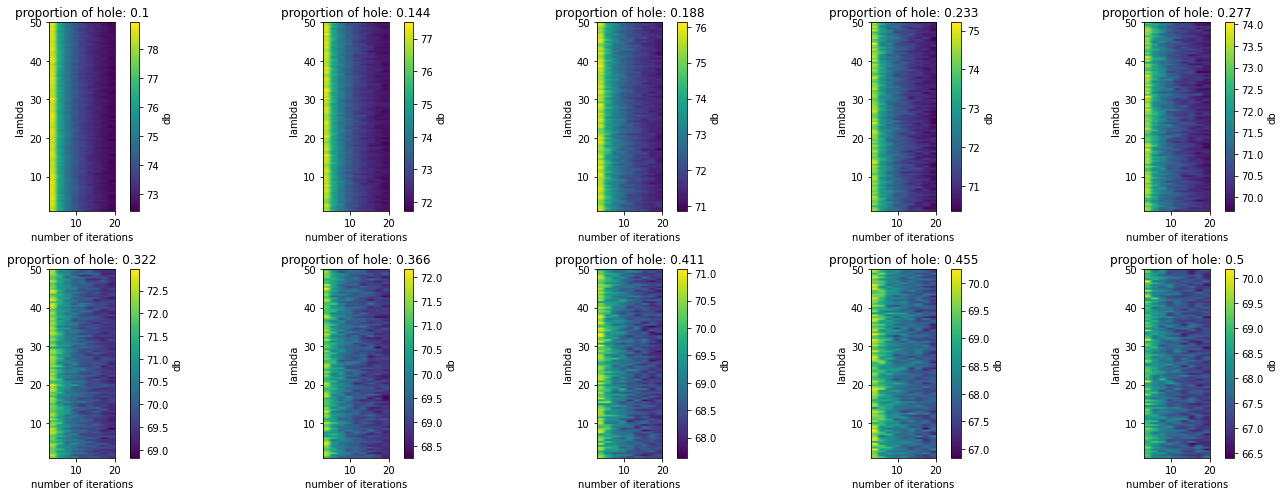

In [59]:
ncols,nrows = 5,2
var = np.linspace(0.1,0.5,ncols*nrows)
V = []
for j in tqdm(range(len(var))):
    K = []
    for lambd in np.linspace(1,50,100):
        psnr = []
        for it in np.arange(3,20,2):
            er = []
            for _ in train:
                x,y = open_frame_gauss(_,var[j])
                y = anisodiff(y,niter=it,lambd=lambd)
                er.append(cv2.PSNR(x,y))
            psnr.append(np.mean(er))
        K.append(psnr)
    V.append(K)
    
np.save('/home/joel/nci-storage/fly_group_behavior/scripts/PeronaMalik/thesis/11_oct/option_1_inpainting.npy',np.array(V))


fig,axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(20,7))

for i in range(len(V)):
    im = axs[i//ncols,i%ncols].imshow(V[i],extent=[3,20,1,50])
    plt.colorbar(im,ax=axs[i//ncols,i%ncols],label='db')
    axs[i//ncols,i%ncols].set_xlabel('number of iterations')
    axs[i//ncols,i%ncols].set_ylabel('lambda')
    axs[i//ncols,i%ncols].set_title(f'proportion of hole: {int(1e3*var[i])/1e3}')
    
plt.tight_layout()
plt.show()

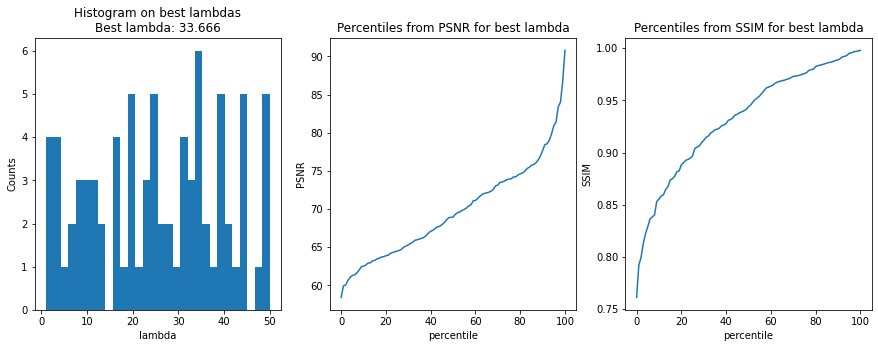

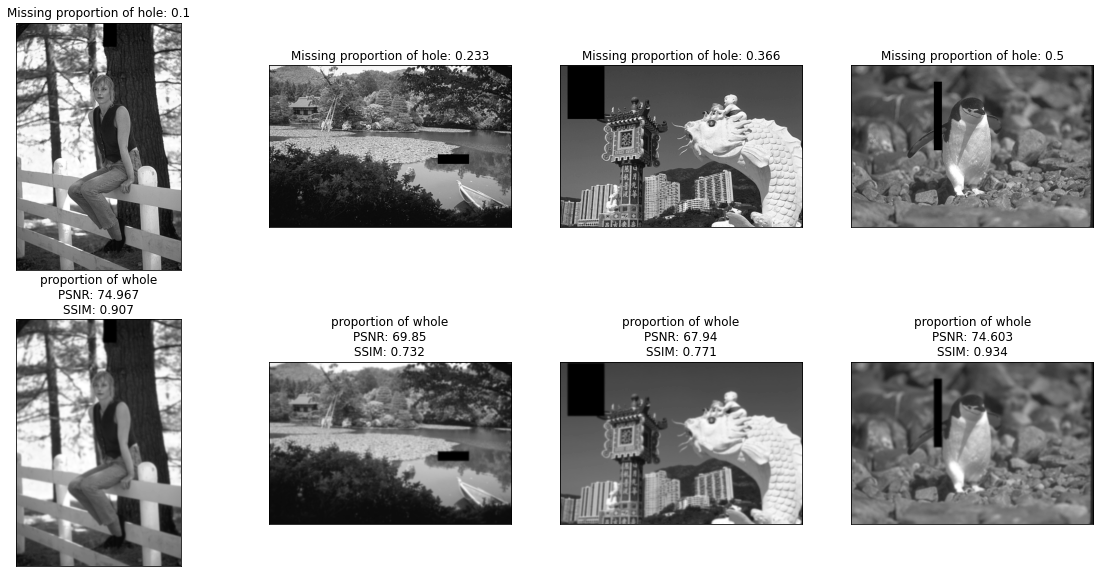

In [60]:
psnr,ssim = [],[]
for _ in test:
    im = open_frame_gauss(_)
    psnr.append(cv2.PSNR(im[0],anisodiff(im[1],option=1)))
    ssim.append(SSIM(im[0],anisodiff(im[1],option=1)))

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.hist(np.linspace(1,50,100)[np.argmax(V[1:],axis=1).flatten()],bins=30)
hist = np.histogram(np.linspace(1,50,100)[np.argmax(V[1:],axis=1).flatten()],bins=30)
best = np.trunc(1e3*hist[1][np.argmax(hist[0])])/1e3
plt.xlabel('lambda')
plt.ylabel('Counts')
plt.title(f'Histogram on best lambdas\nBest lambda: {best}')

plt.subplot(132)
plt.plot(np.percentile(psnr,q=np.arange(0,101,1)))
plt.xlabel('percentile')
plt.ylabel('PSNR')
plt.title('Percentiles from PSNR for best lambda')

plt.subplot(133)
plt.plot(np.percentile(ssim,q=np.arange(0,101,1)))
plt.xlabel('percentile')
plt.ylabel('SSIM')
plt.title('Percentiles from SSIM for best lambda')

plt.show()

ncols = 4
nrows = 2

fig,axs = plt.subplots(nrows = nrows,ncols = ncols,figsize=(20,10))
test = glob('../images/test/*.jpg')
train = glob('../images/train/*.jpg')
val = glob('../images/val/*.jpg')

var = np.linspace(0.1,0.5,ncols)


for j in range(ncols):
    _ = np.random.choice(test)
    im = open_frame_gauss(_,var[j])
    denoised = anisodiff(im[1],niter=10,lambd=best,option=1)
    axs[0,j].imshow(im[1],cmap = 'gray')
    axs[0,j].set_xticks([])
    axs[0,j].set_xticklabels([])
    axs[0,j].set_yticks([])
    axs[0,j].set_yticklabels([])
    axs[0,j].set_title(f'Missing proportion of hole: {int(1e3*var[j])/1e3}')
    
    axs[1,j].imshow(denoised,cmap = 'gray')
    axs[1,j].set_xticks([])
    axs[1,j].set_xticklabels([])
    axs[1,j].set_yticks([])
    axs[1,j].set_yticklabels([])
    axs[1,j].set_title(f'proportion of whole\nPSNR: {np.trunc(1e3*cv2.PSNR(im[0],denoised))/1e3}\nSSIM: {np.trunc(1e3*SSIM(im[0],denoised))/1e3}')
        
        
plt.show()

## option 2

100%|███████████████████████████████████████| 10/10 [5:29:35<00:00, 1977.56s/it]


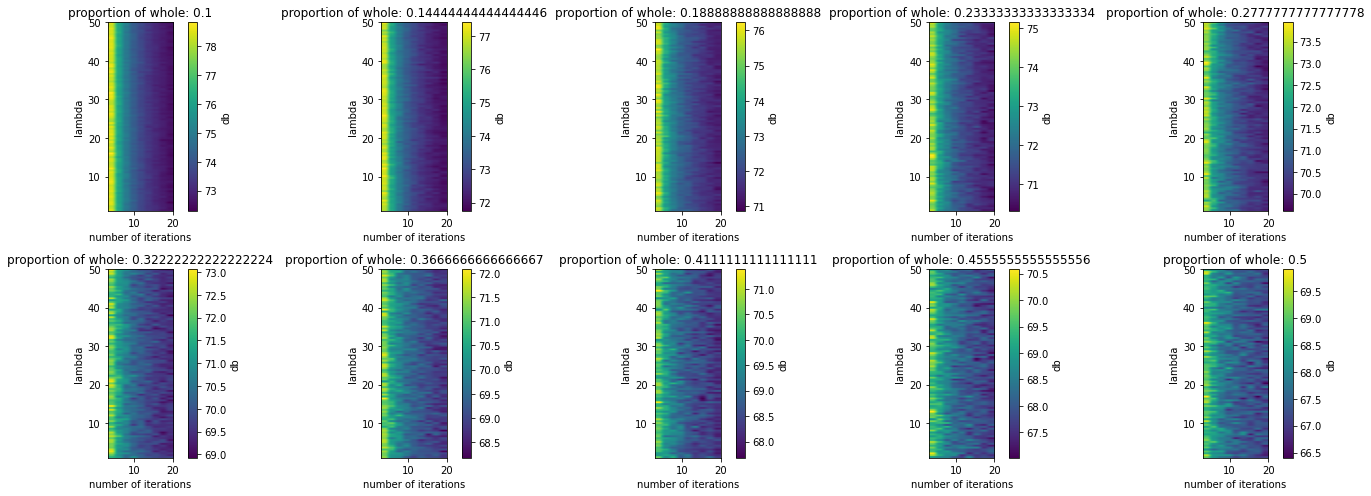

In [61]:
ncols,nrows = 5,2
var = np.linspace(0.1,0.5,ncols*nrows)
V = []
for j in tqdm(range(len(var))):
    K = []
    for lambd in np.linspace(1,50,100):
        psnr = []
        for it in np.arange(3,20,2):
            er = []
            for _ in train:
                x,y = open_frame_gauss(_,var[j])
                y = anisodiff(y,niter=it,lambd=lambd,option=2)
                er.append(cv2.PSNR(x,y))
            psnr.append(np.mean(er))
        K.append(psnr)
    V.append(K)
    
np.save('/home/joel/nci-storage/fly_group_behavior/scripts/PeronaMalik/thesis/11_oct/option_2_inpainting.npy',np.array(V))


fig,axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(20,7))

for i in range(len(V)):
    im = axs[i//ncols,i%ncols].imshow(V[i],extent=[3,20,1,50])
    plt.colorbar(im,ax=axs[i//ncols,i%ncols],label='db')
    axs[i//ncols,i%ncols].set_xlabel('number of iterations')
    axs[i//ncols,i%ncols].set_ylabel('lambda')
    axs[i//ncols,i%ncols].set_title(f'proportion of whole: {var[i]}')
    
plt.tight_layout()
plt.show()

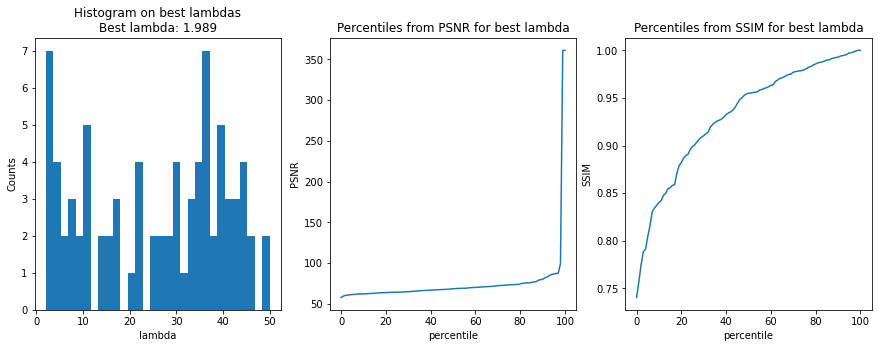

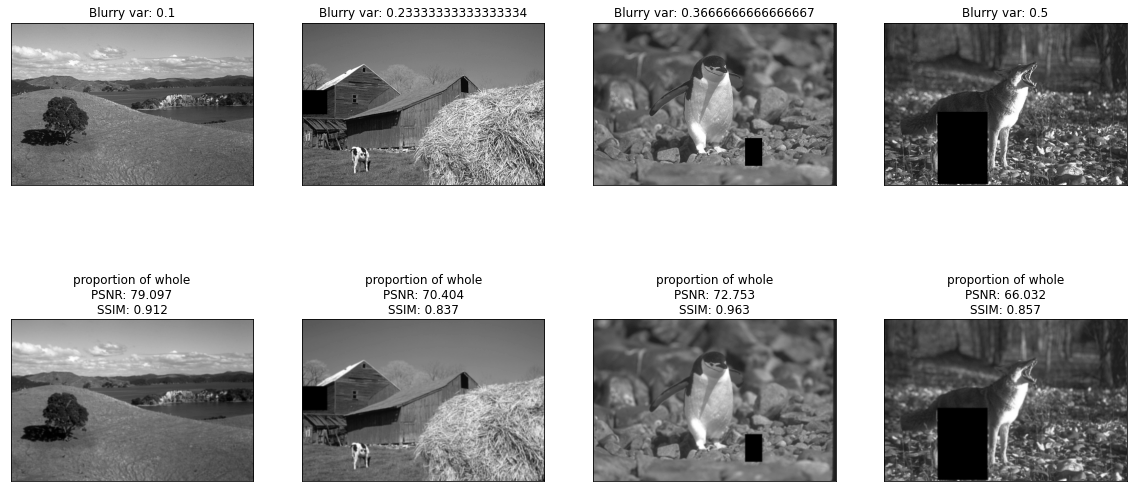

In [62]:
psnr,ssim = [],[]
for _ in test:
    im = open_frame_gauss(_)
    psnr.append(cv2.PSNR(im[0],anisodiff(im[1],option=2)))
    ssim.append(SSIM(im[0],anisodiff(im[1],option=2)))

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.hist(np.linspace(1,50,100)[np.argmax(V[1:],axis=1).flatten()],bins=30)
hist = np.histogram(np.linspace(1,50,100)[np.argmax(V[1:],axis=1).flatten()],bins=30)
best = np.trunc(1e3*hist[1][np.argmax(hist[0])])/1e3
plt.xlabel('lambda')
plt.ylabel('Counts')
plt.title(f'Histogram on best lambdas\nBest lambda: {best}')

plt.subplot(132)
plt.plot(np.percentile(psnr,q=np.arange(0,101,1)))
plt.xlabel('percentile')
plt.ylabel('PSNR')
plt.title('Percentiles from PSNR for best lambda')

plt.subplot(133)
plt.plot(np.percentile(ssim,q=np.arange(0,101,1)))
plt.xlabel('percentile')
plt.ylabel('SSIM')
plt.title('Percentiles from SSIM for best lambda')

plt.show()

ncols = 4
nrows = 2

fig,axs = plt.subplots(nrows = nrows,ncols = ncols,figsize=(20,10))
test = glob('../images/test/*.jpg')
train = glob('../images/train/*.jpg')
val = glob('../images/val/*.jpg')

var = np.linspace(0.1,0.5,ncols)

for j in range(ncols):
    _ = np.random.choice(test)
    im = open_frame_gauss(_,var[j])
    denoised = anisodiff(im[1],niter=5,lambd=best,option=2)
    axs[0,j].imshow(im[1],cmap = 'gray')
    axs[0,j].set_xticks([])
    axs[0,j].set_xticklabels([])
    axs[0,j].set_yticks([])
    axs[0,j].set_yticklabels([])
    axs[0,j].set_title(f'Blurry var: {var[j]}')
    
    axs[1,j].imshow(denoised,cmap = 'gray')
    axs[1,j].set_xticks([])
    axs[1,j].set_xticklabels([])
    axs[1,j].set_yticks([])
    axs[1,j].set_yticklabels([])
    axs[1,j].set_title(f'proportion of whole\nPSNR: {np.trunc(1e3*cv2.PSNR(im[0],denoised))/1e3}\nSSIM: {np.trunc(1e3*SSIM(im[0],denoised))/1e3}')
        
        
plt.show()

# Neural networks

In [69]:
strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.OneDeviceStrategy('/device:GPU:0')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [71]:
def divergence_x(x):
    return(x[:,1:]-x[:,:-1])

def divergence_y(x):
    return(x[:,:,1:]-x[:,:,:-1])

def make_model(input_shape, option=1, num_classes=2):
    inputs = tf.keras.Input(shape=input_shape)
    
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [16,32,64,128]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
        
    activation = "linear"
    units = 1

    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    outputs = tf.keras.layers.Lambda(lambda z: tf.math.pow(z,-2))(outputs)
    

    dx = tf.keras.layers.Lambda(divergence_x)(inputs)
    dy = tf.keras.layers.Lambda(divergence_y)(inputs)

    dx = tf.keras.layers.Lambda(lambda z:tf.image.resize(z,[CROP,CROP]))(dx)
    dy = tf.keras.layers.Lambda(lambda z:tf.image.resize(z,[CROP,CROP]))(dy)
    
    dx2 = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(dx)
    dy2 = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(dy)
    
    norm = tf.keras.layers.add([dx2,dy2])
    
    if option == 1:
        coeff = tf.keras.layers.multiply([outputs,norm])
        coeff = tf.keras.layers.Lambda(lambda z: tf.math.exp(-z))(coeff)
    elif option == 2:
        coeff = tf.keras.layers.multiply([outputs,norm])
        coeff = tf.keras.layers.Lambda(lambda z: 1./(1. + z))(coeff)
        
    outputs_x = tf.keras.layers.multiply([coeff,dx])
    outputs_y = tf.keras.layers.multiply([coeff,dy])

    outputs_x = tf.keras.layers.Lambda(divergence_x)(outputs_x)
    outputs_y = tf.keras.layers.Lambda(divergence_y)(outputs_y)

    outputs_x = tf.keras.layers.Lambda(lambda x:tf.image.resize(x,[CROP,CROP]))(outputs_x)
    outputs_y = tf.keras.layers.Lambda(lambda x:tf.image.resize(x,[CROP,CROP]))(outputs_y)

    outputs = tf.keras.layers.add([outputs_x,outputs_y])
    outputs = tf.keras.layers.Conv2D(1,1,activation="linear",padding="same")(outputs)
    outputs = tf.keras.layers.add([outputs,inputs])
    
    return tf.keras.models.Model(inputs, outputs)



In [89]:
epochs = 200
window = 0.1
X_train,Y_train = [],[]

for _ in train:
    im = open_frame_gauss(_,window=window)
    X_train.append(np.expand_dims(im[1],axis=-1))
    Y_train.append(np.expand_dims(im[0],axis=-1))
    
X_test,Y_test = [],[]

for _ in test:
    im = open_frame_gauss(_,window=window)
    X_test.append(np.expand_dims(im[1],axis=-1))
    Y_test.append(np.expand_dims(im[0],axis=-1))
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath= f"./checkpoints/inpainting_{window}",
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True),
]

def loss_function(y_true, y_pred):
    return 1./tf.image.psnr(y_true,y_pred,max_val = 1.)

def metric(y_true, y_pred):
    return tf.image.ssim(y_true,y_pred,max_val = 1.)

image_size = (CROP,CROP)
with strategy.scope():
    model = make_model(input_shape=image_size + (1,), num_classes=2)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=loss_function,
        metrics=[metric],
    )
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_67 (Conv2D)             (None, 128, 128, 32  320         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_108 (Batch  (None, 128, 128, 32  128        ['conv2d_67[0][0]']              
 Normalization)                 )                                                           

In [90]:
history = model.fit(
    x=X_train,y=Y_train, epochs=epochs, callbacks=callbacks, validation_data=(X_test,Y_test),
)
np.save(f"./history/inpainting_{window}.npy",np.array(list(history.history.values())))

Epoch 1/50


2022-10-17 13:36:34.625712: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_55329"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:693"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. Y

INFO:tensorflow:batch_all_reduce: 65 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 65 all-reduces with algorithm = nccl, num_packs = 1
6/7 [========================>.....] - ETA: 0s - loss: 0.0317 - metric: 0.9734

2022-10-17 13:36:42.426618: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_68369"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:749"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. Y

7/7 [==============================] - 10s 417ms/step - loss: 0.0317 - metric: 0.9733 - val_loss: 0.0270 - val_metric: 0.9958
Epoch 2/50
7/7 [==============================] - 1s 91ms/step - loss: 0.0322 - metric: 0.9714 - val_loss: 0.0270 - val_metric: 0.9960
Epoch 3/50
7/7 [==============================] - 1s 117ms/step - loss: 0.0322 - metric: 0.9709 - val_loss: 0.0277 - val_metric: 0.9935
Epoch 4/50
7/7 [==============================] - 1s 113ms/step - loss: 0.0322 - metric: 0.9725 - val_loss: 0.0282 - val_metric: 0.9908
Epoch 5/50
7/7 [==============================] - 1s 88ms/step - loss: 0.0318 - metric: 0.9750 - val_loss: 0.0281 - val_metric: 0.9911
Epoch 6/50
7/7 [==============================] - 1s 89ms/step - loss: 0.0317 - metric: 0.9754 - val_loss: 0.0275 - val_metric: 0.9941
Epoch 7/50
7/7 [==============================] - 1s 90ms/step - loss: 0.0320 - metric: 0.9748 - val_loss: 0.0272 - val_metric: 0.9956
Epoch 8/50
7/7 [==============================] - 1s 89ms/step

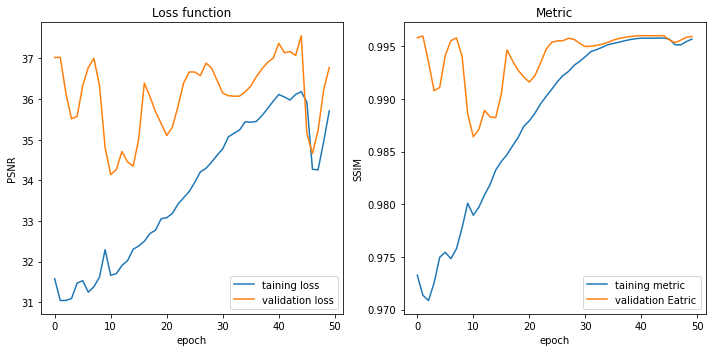

In [91]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(1/np.array(history.history["loss"]),label = "taining loss")
plt.plot(1/np.array(history.history["val_loss"]),label = "validation loss")
plt.title("Loss function")
plt.xlabel("epoch")
plt.ylabel("PSNR")
plt.legend()

plt.subplot(122)
plt.plot(history.history["metric"],label = "taining metric")
plt.plot(history.history["val_metric"],label = "validation Eatric")
plt.title("Metric")
plt.xlabel("epoch")
plt.ylabel("SSIM")
plt.legend()

plt.tight_layout()
plt.show()

In [92]:
ncols,nrows = 4,4
X_val,Y_val = [],[]

for _ in val:
    im = open_frame_gauss(_,window=window)
    X_val.append(np.expand_dims(im[1],axis=-1))
    Y_val.append(np.expand_dims(im[0],axis=-1))
    
X_val,Y_val = np.array(X_val),np.array(Y_val)

inputs = tf.keras.Input(shape=image_size + (1,))
visualization = tf.keras.models.Model(model.input,model.layers[-10].output)

p = model(X_val)
vis = np.squeeze(visualization(X_val))

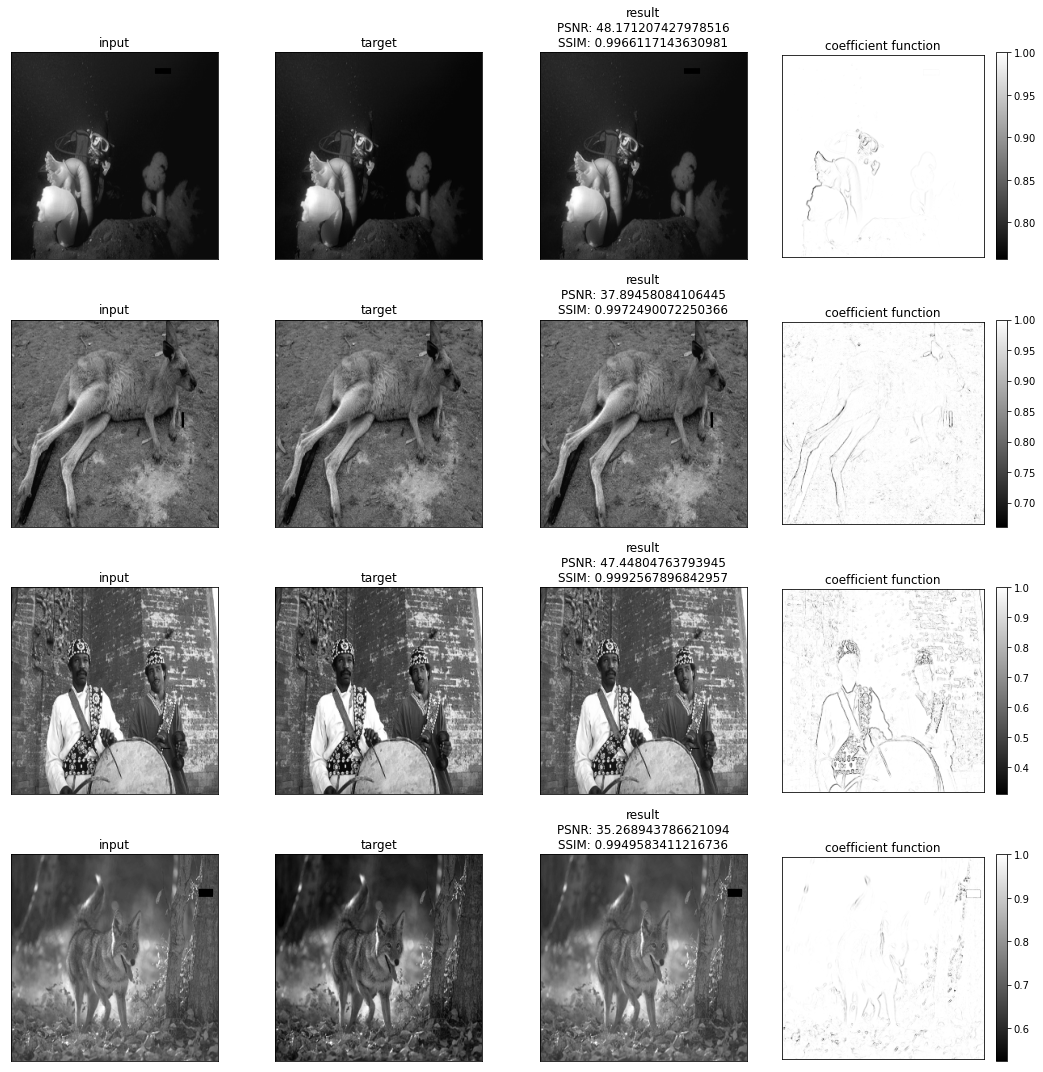

In [93]:
fig,axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(15,15))

for i in range(nrows):
    _ = np.random.choice(len(p))
    
    axs[i,0].imshow(X_val[_],cmap="gray")
    axs[i,0].set_title("input")
    axs[i,0].set_xticks([])
    axs[i,0].set_xticklabels([])
    axs[i,0].set_yticks([])
    axs[i,0].set_yticklabels([])
    axs[i,1].imshow(Y_val[_],cmap="gray")
    axs[i,1].set_title("target")
    axs[i,1].set_xticks([])
    axs[i,1].set_xticklabels([])
    axs[i,1].set_yticks([])
    axs[i,1].set_yticklabels([])
    axs[i,2].imshow(p[_],cmap="gray")
    psnr = tf.image.psnr(Y_val[_],p[_],max_val=1)
    ssim = tf.image.ssim(Y_val[_],p[_],max_val=1)
    axs[i,2].set_title(f"result\nPSNR: {psnr}\nSSIM: {ssim}")
    axs[i,2].set_xticks([])
    axs[i,2].set_xticklabels([])
    axs[i,2].set_yticks([])
    axs[i,2].set_yticklabels([])
    im = axs[i,3].imshow(vis[_],cmap="gray")
    plt.colorbar(im,ax=axs[i,3])
    axs[i,3].set_title("coefficient function")
    axs[i,3].set_xticks([])
    axs[i,3].set_xticklabels([])
    axs[i,3].set_yticks([])
    axs[i,3].set_yticklabels([])
    
plt.tight_layout()
plt.show()

## Training for several windows

In [95]:
epochs = 200
def loss_function(y_true, y_pred):
    return 1./tf.image.psnr(y_true,y_pred,max_val = 1.)

def metric(y_true, y_pred):
    return tf.image.ssim(y_true,y_pred,max_val = 1.)

image_size = (CROP,CROP)

for window in tqdm(np.arange(0.05,0.5,0.05)):
    X_train,Y_train = [],[]

    for _ in train:
        im = open_frame_gauss(_,window=window)
        X_train.append(np.expand_dims(im[1],axis=-1))
        Y_train.append(np.expand_dims(im[0],axis=-1))

    X_test,Y_test = [],[]

    for _ in test:
        im = open_frame_gauss(_,window=window)
        X_test.append(np.expand_dims(im[1],axis=-1))
        Y_test.append(np.expand_dims(im[0],axis=-1))

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath= f"./checkpoints/inpainting_{window}",
        save_weights_only=True,
        monitor='val_loss',
        mode='max',
        save_best_only=True),
    ]


    with strategy.scope():
        model = make_model(input_shape=image_size + (1,), num_classes=2)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(1e-3),
            loss=loss_function,
            metrics=[metric],
        )
        
    history = model.fit(
        x=X_train,y=Y_train, epochs=epochs, callbacks=callbacks, validation_data=(X_test,Y_test),
    )
    np.save(f"./history/inpainting_{window}.npy",np.array(list(history.history.values())))

  0%|                                                     | 0/9 [00:00<?, ?it/s]2022-10-17 13:43:46.549993: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_90834"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:1382"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off 

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 65 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 65 all-reduces with algorithm = nccl, num_packs = 1
6/7 [========================>.....] - ETA: 0s - loss: 0.0461 - metric: 0.7530

2022-10-17 13:43:54.292870: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_103874"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:1438"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset.

7/7 [==============================] - 10s 420ms/step - loss: 0.0460 - metric: 0.7533 - val_loss: 0.0243 - val_metric: 0.9911
Epoch 2/200
7/7 [==============================] - 1s 90ms/step - loss: 0.0458 - metric: 0.7547 - val_loss: 0.0236 - val_metric: 0.9964
Epoch 3/200
7/7 [==============================] - 1s 88ms/step - loss: 0.0469 - metric: 0.7475 - val_loss: 0.0238 - val_metric: 0.9965
Epoch 4/200
7/7 [==============================] - 1s 92ms/step - loss: 0.0451 - metric: 0.7634 - val_loss: 0.0233 - val_metric: 0.9975
Epoch 5/200
7/7 [==============================] - 1s 91ms/step - loss: 0.0457 - metric: 0.7639 - val_loss: 0.0240 - val_metric: 0.9935
Epoch 6/200
7/7 [==============================] - 1s 87ms/step - loss: 0.0459 - metric: 0.7571 - val_loss: 0.0236 - val_metric: 0.9969
Epoch 7/200
7/7 [==============================] - 1s 113ms/step - loss: 0.0466 - metric: 0.7468 - val_loss: 0.0299 - val_metric: 0.9296
Epoch 8/200
7/7 [==============================] - 1s 115

Epoch 61/200
7/7 [==============================] - 1s 88ms/step - loss: 0.0383 - metric: 0.8562 - val_loss: 0.0345 - val_metric: 0.8890
Epoch 62/200
7/7 [==============================] - 1s 91ms/step - loss: 0.0386 - metric: 0.8526 - val_loss: 0.0350 - val_metric: 0.8852
Epoch 63/200
7/7 [==============================] - 1s 89ms/step - loss: 0.0389 - metric: 0.8497 - val_loss: 0.0330 - val_metric: 0.9066
Epoch 64/200
7/7 [==============================] - 1s 90ms/step - loss: 0.0373 - metric: 0.8658 - val_loss: 0.0321 - val_metric: 0.9181
Epoch 65/200
7/7 [==============================] - 1s 90ms/step - loss: 0.0383 - metric: 0.8608 - val_loss: 0.0276 - val_metric: 0.9660
Epoch 66/200
7/7 [==============================] - 1s 89ms/step - loss: 0.0389 - metric: 0.8579 - val_loss: 0.0299 - val_metric: 0.9399
Epoch 67/200
7/7 [==============================] - 1s 91ms/step - loss: 0.0384 - metric: 0.8615 - val_loss: 0.0271 - val_metric: 0.9658
Epoch 68/200
7/7 [=======================

  0%|                                                     | 0/9 [01:11<?, ?it/s]


KeyboardInterrupt: 